# Data ingestion

In [ ]:
import kagglehub
import shutil

# Download latest version
path = kagglehub.dataset_download("thoughtvector/customer-support-on-twitter")
# Move the files to the data/raw folder
shutil.move(path, "../data/raw")

# E.D.A

In [ ]:
import pandas as pd

## Reading the data

In [ ]:
# Reading the complete dataset
data_complete = pd.read_csv('../data/raw/10/twcs/twcs.csv')

# Sampling the dada
data_sample = data_complete.sample(n=50000, random_state=22)

# Unloading the complete dataset
del data_complete

## First glance at the Data

In [28]:
# Shapes of the data
data_sample.shape

(50000, 7)

In [29]:
# First glance at the columns
data_sample.columns

Index(['tweet_id', 'author_id', 'inbound', 'created_at', 'text',
       'response_tweet_id', 'in_response_to_tweet_id'],
      dtype='object')

In [30]:
# Looking at the dtypes
data_sample.dtypes

# Here we can see that the data has some columns that are in the wrong format,
# like the 'created_at' column, which is a string, but should be a timestamp.

tweet_id                     int64
author_id                   object
inbound                       bool
created_at                  object
text                        object
response_tweet_id           object
in_response_to_tweet_id    float64
dtype: object

In [ ]:
# Looking at NA values
data_sample.isna().sum()

# We can see that there are some NA values in the 'response_tweet_id' and 'in_responso_to_tweet_id' columns

tweet_id                       0
author_id                      0
inbound                        0
created_at                     0
text                           0
response_tweet_id          18402
in_response_to_tweet_id    14173
dtype: int64

In [32]:
# Overview of the data
data_sample.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
1711915,1866134,557521,True,Wed Oct 18 07:47:48 +0000 2017,I survived the @sainsburys 2017 toy sale. http...,"1866135,1866133",NaN
2719109,2894171,802094,True,Mon Nov 27 08:39:10 +0000 2017,@AskPlayStation my HDMI port stopped working o...,2894169,NaN
718797,803619,XboxSupport,False,Thu Oct 12 16:53:27 +0000 2017,"@310023 Hi there, when you get a moment what y...",NaN,803618.0
899788,999369,356632,True,Wed Oct 18 14:53:21 +0000 2017,@ATVIAssist My stats there not mine they fake ...,NaN,999368.0
2720137,2895215,802343,True,Tue Nov 28 15:55:15 +0000 2017,@CoxHelp Message sent.,NaN,2895214.0


In [ ]:
# Looking at the author_id column
data_sample['author_id'].value_counts().sort_values(ascending=False)

# We can see that company tweets is most common

author_id
AmazonHelp      3015
AppleSupport    1885
Uber_Support    1001
Delta            759
SpotifyCares     757
                ... 
505368             1
603466             1
393694             1
289381             1
375342             1
Name: count, Length: 26450, dtype: int64

In [ ]:
# Filtering the data to only include tweets from companies
mask = data_sample['author_id'].str.contains(r'[A-Za-z]', na=False)

# Count and order the tweets from companies
company_counts = (
    data_sample.loc[mask, 'author_id']
    .value_counts()
    .sort_values(ascending=False)
)

print(company_counts)

# So we can see there are 108 campanys in the sample, and the most common is Amazon, Apple, Uber, Delta and spotify

author_id
AmazonHelp        3015
AppleSupport      1885
Uber_Support      1001
Delta              759
SpotifyCares       757
                  ... 
CarlsJr              5
AskDSC               4
OfficeSupport        3
HotelTonightCX       2
JackBox              2
Name: count, Length: 108, dtype: int64


In [37]:
import numpy as np

# Make sure datetime is correct
data_sample['created_at'] = pd.to_datetime(
    data_sample['created_at'], utc=True, errors='coerce'
)

# Normalize the tweet id to integer null (Int64)
resp_to = pd.to_numeric(
    data_sample['in_response_to_tweet_id'], errors='coerce'
).astype('Int64')
data_sample['in_response_to_tweet_id_norm'] = resp_to


data_sample.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,in_response_to_tweet_id_norm
1711915,1866134,557521,True,2017-10-18 07:47:48+00:00,I survived the @sainsburys 2017 toy sale. http...,"1866135,1866133",NaN,<NA>
2719109,2894171,802094,True,2017-11-27 08:39:10+00:00,@AskPlayStation my HDMI port stopped working o...,2894169,NaN,<NA>
718797,803619,XboxSupport,False,2017-10-12 16:53:27+00:00,"@310023 Hi there, when you get a moment what y...",NaN,803618.0,803618
899788,999369,356632,True,2017-10-18 14:53:21+00:00,@ATVIAssist My stats there not mine they fake ...,NaN,999368.0,999368
2720137,2895215,802343,True,2017-11-28 15:55:15+00:00,@CoxHelp Message sent.,NaN,2895214.0,2895214


In [38]:
# Responses from companies with valid reference to the original tweet
is_reply = (
    (data_sample['inbound'] == False) &
    (data_sample['in_response_to_tweet_id_norm'].notna())
)

replies = data_sample.loc[
    is_reply,
    ['tweet_id', 'author_id', 'created_at', 'in_response_to_tweet_id_norm']
].rename(columns={'created_at': 'reply_time'})

# Original tweets (can be from customer or company)
orig = data_sample.loc[
    :, ['tweet_id', 'author_id', 'inbound', 'created_at']
].rename(columns={
    'tweet_id': 'orig_tweet_id',
    'author_id': 'orig_author_id',
    'created_at': 'orig_time'
})

# Merge each response to the original tweet
resp_df = replies.merge(
    orig,
    left_on='in_response_to_tweet_id_norm',
    right_on='orig_tweet_id',
    how='left'
)

# Keep customer -> company interactions (inbound True)
resp_df = resp_df.loc[resp_df['inbound'] == True].copy()

# Calculate response time in minutes (non-negative)
resp_df['response_time_min'] = (
    (resp_df['reply_time'] - resp_df['orig_time']).dt.total_seconds() / 60.0
)
resp_df = resp_df.loc[
    resp_df['response_time_min'].notna() & (resp_df['response_time_min'] >= 0)
].copy()

# Optional: column in hours for reading
resp_df['response_time_h'] = resp_df['response_time_min'] / 60.0

resp_df[['tweet_id', 'author_id', 'orig_tweet_id',
         'response_time_min', 'response_time_h']].head()

,tweet_id,author_id,orig_tweet_id,response_time_min,response_time_h
53,1908454,AmericanAir,1908456.0,10.950000,0.182500
101,26135,SW_Help,26133.0,12.033333,0.200556
133,2267444,AskLyft,2267445.0,22.983333,0.383056
141,1452676,Safaricom_Care,1452677.0,80.583333,1.343056
240,1330317,sprintcare,1330318.0,1.616667,0.026944


In [39]:
# Getting some statistics about response time


rt = resp_df['response_time_min']

desc = rt.describe(percentiles=[.25, .5, .75, .9, .95, .99])
iqr = desc['75%'] - desc['25%']
upper_fence = desc['75%'] + 1.5 * iqr

print('Resumo (min):')
print(desc.round(2))
print(f'IQR: {iqr:.2f} | Limite sup (1.5*IQR): {upper_fence:.2f}')
print(f'Outliers acima do limite: {(rt > upper_fence).sum()}')

Resumo (min):
count      430.00
mean       518.66
std       4240.50
min          0.55
25%          6.69
50%         24.12
75%        108.85
90%        583.45
95%       1459.85
99%       7472.01
max      85057.85
Name: response_time_min, dtype: float64
IQR: 102.16 | Limite sup (1.5*IQR): 262.08
Outliers acima do limite: 71


In [40]:
# Some visualizations

import matplotlib.pyplot as plt
import seaborn as sns

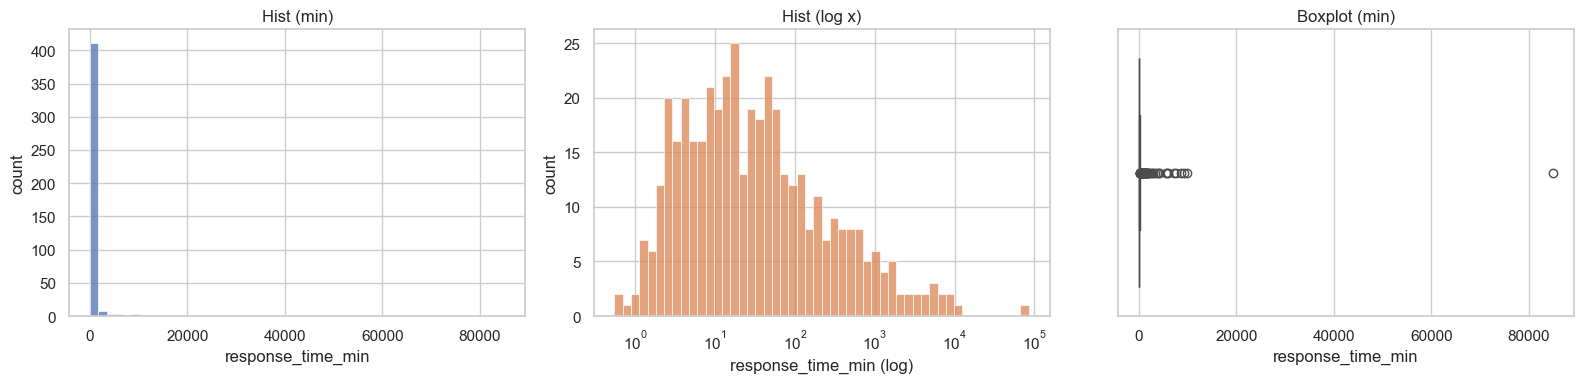

In [41]:
sns.set(style='whitegrid')
rt = resp_df['response_time_min']

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Linear histogram
sns.histplot(rt, bins=50, kde=False, ax=axes[0], color='#4c72b0')
axes[0].set_title('Hist (min)')
axes[0].set_xlabel('response_time_min')
axes[0].set_ylabel('count')

# Log histogram
sns.histplot(rt, bins=50, kde=False, ax=axes[1], color='#dd8452', log_scale=True)
axes[1].set_title('Hist (log x)')
axes[1].set_xlabel('response_time_min (log)')
axes[1].set_ylabel('count')

# Boxplot
sns.boxplot(x=rt, ax=axes[2], color='#55a868')
axes[2].set_title('Boxplot (min)')
axes[2].set_xlabel('response_time_min')

plt.tight_layout()
plt.show()

author_id
NortonSupport      2.3
CenturyLinkHelp    2.3
YahooCare          2.4
AlaskaAir          2.4
JetBlue            2.8
AskLyft            3.3
USCellularCares    3.5
TMobileHelp        3.6
AirbnbHelp         3.8
AzureSupport       3.9
VerizonSupport     4.3
DoorDash_Help      4.6
ArgosHelpers       6.0
VirginAtlantic     7.2
nationalrailenq    7.9
Name: response_time_min, dtype: float64


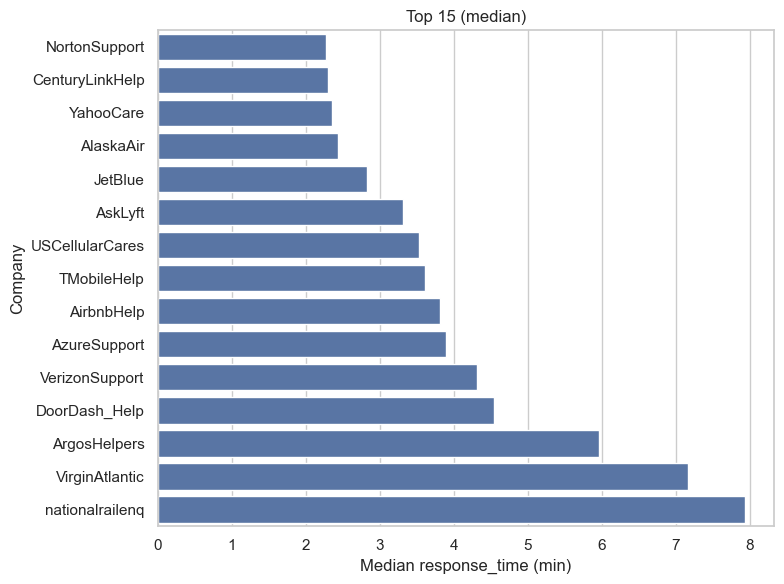

In [42]:
# Visualizing the response time by company
by_company = resp_df.groupby('author_id')['response_time_min']
company_median = by_company.median().sort_values()

top15 = company_median.head(15)
print(top15.round(1))

plt.figure(figsize=(8, 6))
sns.barplot(
    x=top15.values,
    y=top15.index,
    color='#4c72b0',
    orient='h'
)
plt.xlabel('Median response_time (min)')
plt.ylabel('Company')
plt.title('Top 15 (median)')
plt.tight_layout()
plt.show()

## Creating target variable

In [ ]:
# Installing dependencies
#!pip -q install transformers torch accelerate tqdm

# Importing dependencies
import re
import math
import torch
from tqdm.auto import tqdm
from transformers import pipeline

In [ ]:
# Converting tweet_id and in_response_to_tweet_id to Int64
data_sample['tweet_id'] = pd.to_numeric(
    data_sample['tweet_id'], errors='coerce'
).astype('Int64')

data_sample['in_response_to_tweet_id'] = pd.to_numeric(
    data_sample['in_response_to_tweet_id'], errors='coerce'
).astype('Int64')

# Creating a dictionary to map the relation between tweet_id and in_response_to_tweet_id
parent_of = dict(
    data_sample[['tweet_id', 'in_response_to_tweet_id']]
    .dropna().to_numpy()
)


# Root of conversation = last message of the conversation
root_cache = {}

def get_root(tid, max_steps=50):
    x = tid
    path = []
    steps = 0
    while True:
        if x in root_cache:
            root = root_cache[x]
            break
        parent = parent_of.get(x, np.nan)
        if pd.isna(parent) or parent not in parent_of:
            root = x
            break
        if steps >= max_steps:  # proteção a ciclos/threads longas
            root = x
            break
        path.append(x)
        x = parent
        steps += 1
    for p in path:
        root_cache[p] = root
    return root

tqdm.pandas(desc='Computando conversation_id')
data_sample['conversation_id'] = data_sample['tweet_id'].progress_apply(
    get_root
).astype('Int64')

Computando conversation_id: 100%|██████████| 50000/50000 [00:00<00:00, 410250.63it/s]


In [ ]:
# Validation of the conversation_id column

tam = (data_sample.groupby('conversation_id')['tweet_id']
       .size().sort_values(ascending=False))
print('Big Threads:', tam.head(10).to_dict())

ex_conv = tam.index[0]
print('\nExample:')
cols = ['conversation_id', 'tweet_id', 'inbound', 'author_id',
        'in_response_to_tweet_id', 'created_at']
display(data_sample.loc[
    data_sample['conversation_id'] == ex_conv, cols
].sort_values('created_at').head(10))

Threads maiores: {np.int64(1034144): 3, np.int64(2463032): 3, np.int64(2492749): 3, np.int64(393353): 2, np.int64(652057): 2, np.int64(1453666): 2, np.int64(812163): 2, np.int64(93667): 2, np.int64(117086): 2, np.int64(1427765): 2}

Exemplo de conversa:


,conversation_id,tweet_id,inbound,author_id,in_response_to_tweet_id,created_at
931957,1034144,1034144,False,AskPayPal,1034145,2017-10-20 05:03:27+00:00
931956,1034144,1034137,True,364651,1034144,2017-10-20 08:57:50+00:00
931948,1034144,1034135,False,AskPayPal,1034137,2017-10-23 06:11:28+00:00


In [48]:
# Normalize datetime
data_sample['created_at'] = pd.to_datetime(
    data_sample['created_at'], utc=True, errors='coerce'
)

# Detect text column
text_col = ['text']
# Detect conversation column
conv_col = 'conversation_id'

In [ ]:
# Using the last tweet of the conversation
df_cli = data_sample.loc[
    data_sample['inbound'] == True,
    [conv_col, 'tweet_id', 'created_at', text_col]
].copy()

df_cli = df_cli.sort_values([conv_col, 'created_at'])

idx_last = df_cli.groupby(conv_col)['created_at'].idxmax()
ultimo_cliente = df_cli.loc[idx_last].reset_index(drop=True)

# Clean text
ultimo_cliente['text_clean'] = (
    ultimo_cliente[text_col].astype(str)
    .str.replace(r'\s+', ' ', regex=True).str.strip()
)

# Remove NA
ultimo_cliente = ultimo_cliente.loc[
    ultimo_cliente['text_clean'].str.len() > 0
].reset_index(drop=True)

ultimo_cliente.head(3)